In [12]:
%pip install tensorflow librosa matplotlib

Note: you may need to restart the kernel to use updated packages.


In [13]:
import tensorflow as tf
import librosa 
import numpy as np
import matplotlib.pyplot as plt

In [14]:
file_path = 'recordings/asistent.wav' 
signal, sample_rate = librosa.load(file_path, sr=None)  # sr=None keeps the original sample rate
print("Sample Rate:", sample_rate)
print("Signal Shape:", signal.shape)

print(signal)


Sample Rate: 44100
Signal Shape: (220160,)
[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  6.4086914e-04
  3.6621094e-04  4.5776367e-04]


In [15]:
signal_tensor = tf.convert_to_tensor(signal, dtype=tf.float32)
signal_tensor = tf.expand_dims(signal_tensor, 0)  # Add batch dimension

print(signal_tensor.shape)

(1, 220160)


In [16]:
# Parameters for STFT and MFCCs
frame_length = 1024  # 64 ms window
frame_step = 256     # 75% overlap (16 ms step)
fft_length = 1024
num_mel_bins = 80
lower_edge_hertz = 80.0
upper_edge_hertz = 7600.0

# Compute STFT (Short-Time Fourier Transform)
stfts = tf.signal.stft(
    signal_tensor,  # Use the first (and only) element of the batch
    frame_length=frame_length,
    frame_step=frame_step,
    fft_length=fft_length,
    window_fn=tf.signal.hamming_window
)

spectrograms = tf.abs(stfts)
np.savetxt("spectro_python.txt", spectrograms[0], fmt='%.6f') 
print(spectrograms.shape)

# Mel filterbank
num_spectrogram_bins = stfts.shape[-1]
print("Number of spectogram (frequency) bins:", num_spectrogram_bins)

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=num_mel_bins,
    num_spectrogram_bins=num_spectrogram_bins,
    sample_rate=sample_rate,
    lower_edge_hertz=lower_edge_hertz,
    upper_edge_hertz=upper_edge_hertz
)

print(linear_to_mel_weight_matrix.shape)

(1, 857, 513)
Number of spectogram (frequency) bins: 513
(513, 80)


In [17]:
# Apply the mel filterbank
mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, axes=1)
print(mel_spectrograms.shape)
mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate([num_mel_bins]))
print(mel_spectrograms.shape)
np.savetxt("mel_spectro_python.txt", mel_spectrograms[0], fmt='%.6f') 



(1, 857, 80)
(1, 857, 80)


In [18]:


# Compute log-magnitude mel-spectrograms
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
np.savetxt("log_mel_spectro_python.txt", log_mel_spectrograms[0], fmt='%.6f') 
print(log_mel_spectrograms.shape)

# Compute MFCCs from log_mel_spectrograms and take the first 13 coefficients
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
np.savetxt("mfccs_python.txt", mfccs[0], fmt='%.6f') 
print("MFCCs shape:", mfccs.shape)

# Remove batch dimension and convert to NumPy for further processing or visualization
mfccs = mfccs.numpy()

print("MFCCs shape:", mfccs.shape)

(1, 857, 80)
MFCCs shape: (1, 857, 13)
MFCCs shape: (1, 857, 13)


In [23]:
# Remove the batch dimension for visualization
mfccs_reshaped = mfccs[0]  # Shape: (857, 13)
print(mfccs_reshaped.shape)

(857, 13)


In [24]:
mfccs_file_path = "mfccs_c.txt"  # Change this to your MFCC file path
mfccs_c = np.loadtxt(mfccs_file_path)
print(mfccs_c.shape)

(857, 13)


Shapes are the same.


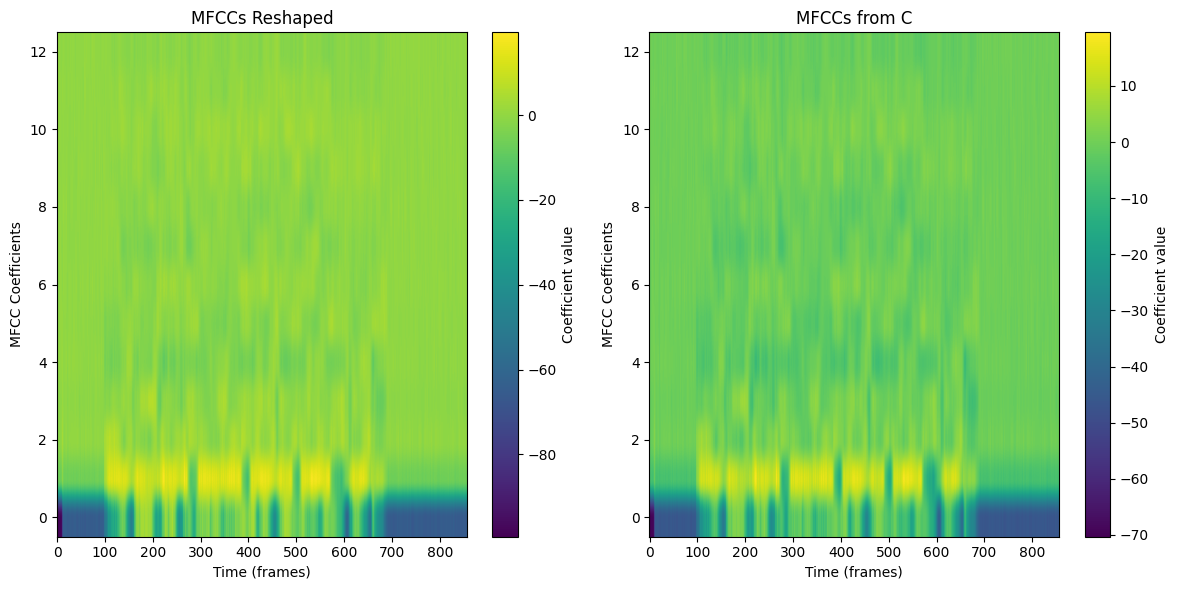

The MFCCs are different.
Mean Squared Error between the two MFCC sets: 11.304536
Mean MFCCs from Reshaped: [-31.32521      3.7676368    0.6520241   -0.4154175   -2.2698824
  -0.9792605   -0.04868997  -1.1858754   -0.7483445    0.03271208
   0.7261436   -0.03535601  -0.890416  ]
Mean MFCCs from C: [-22.15448743   3.76719757   0.65158203  -0.41615245  -2.27092771
  -0.98116703  -0.04995451  -1.18667207  -0.74975754   0.03108684
   0.72472055  -0.03562802  -0.89145665]
Variance MFCCs from Reshaped: [732.8189    102.25088     5.847074    6.2330427   6.962707    4.182704
   2.3761559   2.9859      1.7882178   2.0464926   1.5854765   1.1407232
   1.196301 ]
Variance MFCCs from C: [366.43289833 102.25642292   5.84569741   6.23348333   6.96383959
   4.18323048   2.37569418   2.9854092    1.78869052   2.04652533
   1.5852295    1.14069361   1.1968609 ]
Mean difference: [9.17072314e+00 4.39210043e-04 4.42056451e-04 7.34958019e-04
 1.04527239e-03 1.90652959e-03 1.26454453e-03 7.96655377e-04
 1.41

In [29]:
# Step 1: Check shapes
if mfccs_reshaped.shape != mfccs_c.shape:
    print("Shapes are different!")
    print("Shape of MFCCs Reshaped:", mfccs_reshaped.shape)
    print("Shape of MFCCs C:", mfccs_c.shape)
else:
    print("Shapes are the same.")

# Step 2: Visualize the MFCCs side by side
plt.figure(figsize=(12, 6))

# Plot MFCCs from reshaped data
plt.subplot(1, 2, 1)
plt.imshow(mfccs_reshaped.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('MFCCs Reshaped')
plt.xlabel('Time (frames)')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Coefficient value')

# Plot MFCCs from C data
plt.subplot(1, 2, 2)
plt.imshow(mfccs_c.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('MFCCs from C')
plt.xlabel('Time (frames)')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Coefficient value')

plt.tight_layout()
plt.show()

# Step 3: Quantitative comparison
# Calculate absolute difference
difference = np.abs(mfccs_reshaped - mfccs_c)

# Step 4: Check if they are equal within a small tolerance
tolerance = 1e-6  # Define a small tolerance
if np.all(difference < tolerance):
    print("The MFCCs are identical within the tolerance.")
else:
    print("The MFCCs are different.")
    # Mean Squared Error
    mse = np.mean(difference**2)
    print(f"Mean Squared Error between the two MFCC sets: {mse:.6f}")

# Step 5: Mean and Variance Comparison
mean_mfcc_reshaped = np.mean(mfccs_reshaped, axis=0)
mean_mfcc_c = np.mean(mfccs_c, axis=0)

print("Mean MFCCs from Reshaped:", mean_mfcc_reshaped)
print("Mean MFCCs from C:", mean_mfcc_c)

# Variance
var_mfcc_reshaped = np.var(mfccs_reshaped, axis=0)
var_mfcc_c = np.var(mfccs_c, axis=0)

print("Variance MFCCs from Reshaped:", var_mfcc_reshaped)
print("Variance MFCCs from C:", var_mfcc_c)

# Final comparison of means and variances
mean_difference = np.abs(mean_mfcc_reshaped - mean_mfcc_c)
var_difference = np.abs(var_mfcc_reshaped - var_mfcc_c)

print("Mean difference:", mean_difference)
print("Variance difference:", var_difference)

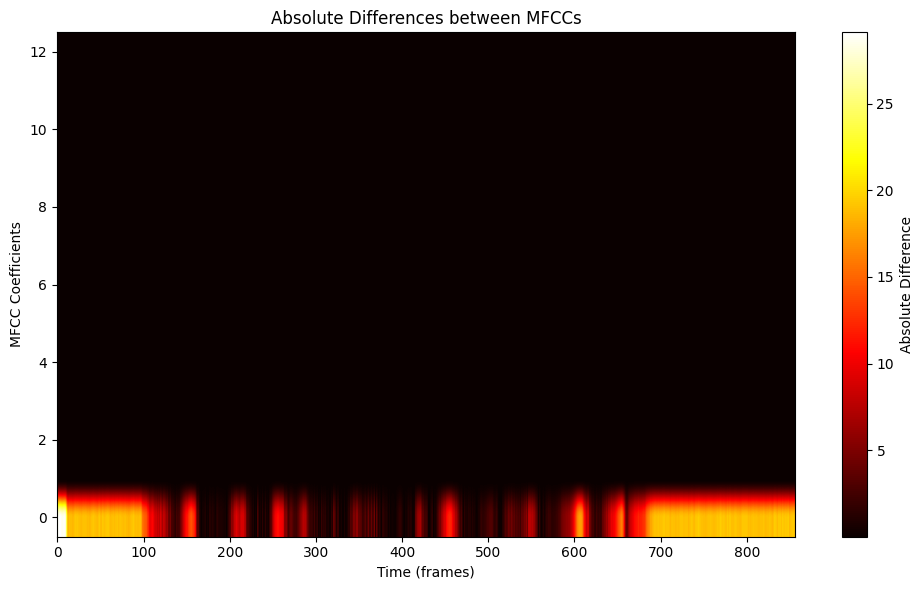

In [30]:
# Plot absolute differences
difference_abs = np.abs(mfccs_reshaped - mfccs_c)

plt.figure(figsize=(10, 6))
plt.imshow(difference_abs.T, aspect='auto', origin='lower', cmap='hot')
plt.title('Absolute Differences between MFCCs')
plt.xlabel('Time (frames)')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Absolute Difference')
plt.tight_layout()
plt.show()